In [1]:
import pandas as pd
import geopandas as gpd
import os
import pylab as plt
from importlib import reload
import emdat_df
reload(emdat_df)
from emdat_df import emdat
import utils
reload(utils)
from utils import get_GNI, get_pop
import fuzzywuzzy as fw
import geocoder

import datetime
import wbdata
%pylab inline

data = os.getenv('data')

Populating the interactive namespace from numpy and matplotlib


/home/nicholasjones/miniconda3/envs/GPD3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Parsing the location field of EMDAT

#### 1. Load downloaded Excel file as a PyEmdat object

In [2]:
ED = emdat((data + '/emdat_1960.xlsx'))

/home/nicholasjones/Code/pyEmdat/emdat_df.py:40: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  self.data = pd.read_excel(filename, header = 6).rename(columns = cols_dict)


#### 2. Summary for Argentina by hazard

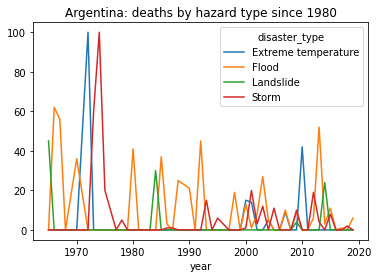

In [19]:
df = ED.disaster_stats_timeseries(1960, 2020, 'Argentina','all','deaths')
df = df.drop(columns = ['Transport accident','Miscellaneous accident','Industrial accident','Epidemic'])
cols_over_100 = [column for column in df.columns if df[column].sum() > 100]
df[cols_over_100].plot(title = 'Argentina: deaths by hazard type since 1980');

#### 3. Flood damages

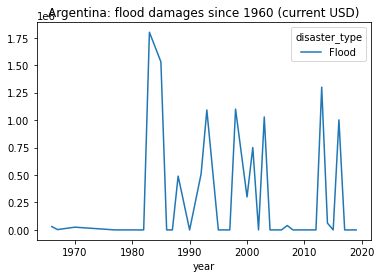

In [43]:
df = ED.disaster_stats_timeseries(1960, 2020, 'Argentina','Flood','total_damages')
df.plot(title = 'Argentina: flood damages since 1960 (current USD)');

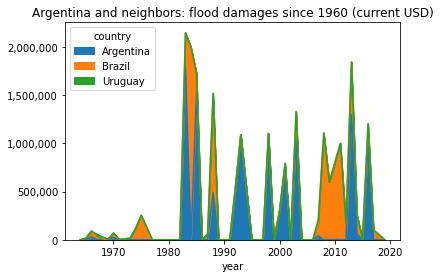

In [107]:
df = ED.country_stats_timeseries(1960, 2020, ['Argentina','Brazil','Uruguay'],'Flood','total_damages')
ax = df.plot.area(title = 'Argentina and neighbors: flood damages since 1960 (current USD)')
y_labels = ax.get_yticks()
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'));

#### 4.Explore location field

In [109]:
df = ED.data
df = df[(df.country == 'Argentina') & (df.disaster_type == 'Flood')][['dis_no', 'country', 'year', 'disaster_group', 'disaster_subgroup',
       'disaster_type', 'disaster_subtype', 'Disaster Subsubtype','event_name', 
       'location', 'lat', 'lon', 'deaths', 'injured', 'affected', 'homeless',
       'total_affected', 'reconstruction_costs', 'insured_damages','total_damages', 'CPI']].reset_index(drop=True)

In [110]:
df.head(2)

,dis_no,country,year,disaster_group,disaster_subgroup,disaster_type,disaster_subtype,Disaster Subsubtype,event_name,location,...,lon,deaths,injured,affected,homeless,total_affected,reconstruction_costs,insured_damages,total_damages,CPI
0,1966-0031-ARG,Argentina,1966,Natural,Hydrological,Flood,Riverine flood,NaN,NaN,North West,...,NaN,62.0,NaN,120000.0,NaN,120000.0,NaN,NaN,30000.0,12.696028
1,1967-0064-ARG,Argentina,1967,Natural,Hydrological,Flood,NaN,NaN,NaN,Buenos Aires suburbs,...,NaN,56.0,NaN,142000.0,70000.0,212000.0,NaN,NaN,3000.0,13.048062


In [111]:
df[['location','disaster_type','event_name','total_damages','insured_damages','reconstruction_costs','deaths','injured','year']]

,location,disaster_type,event_name,total_damages,insured_damages,reconstruction_costs,deaths,injured,year
0,North West,Flood,NaN,30000.0,NaN,NaN,62.0,NaN,1966
1,Buenos Aires suburbs,Flood,NaN,3000.0,NaN,NaN,56.0,NaN,1967
2,Mendoza,Flood,NaN,25000.0,NaN,NaN,36.0,NaN,1970
3,"North-East, Central",Flood,NaN,NaN,NaN,NaN,NaN,NaN,1977
4,"Central, Northern",Flood,NaN,NaN,NaN,NaN,NaN,NaN,1978
...,...,...,...,...,...,...,...,...,...
59,Chaco and Salta Province,Flood,NaN,NaN,NaN,NaN,NaN,NaN,2018
60,"Santa Mónica, Tiro Federal, Ginés Benítez, Mon...",Flood,NaN,NaN,NaN,NaN,NaN,NaN,2018
61,"Corrientes, Santiago del Estero, Chaco, Tucumá...",Flood,NaN,NaN,NaN,NaN,4.0,NaN,2019
62,"Resistencia, Barranqueras, General Pinedo, Cha...",Flood,NaN,NaN,NaN,NaN,2.0,NaN,2019


In [112]:
# there are 64 flood events in the database since 1960

In [113]:
df.location.tolist()

['North West',
 'Buenos Aires suburbs',
 'Mendoza',
 'North-East, Central',
 'Central, Northern',
 'Formosa, Misiones',
 'Northwestern',
 'Buenos Aires province',
 nan,
 'Northeast region',
 nan,
 'Berisso, Moron, Avellaneda, San Martin, La Plata, General Sarmiento, San Isidro, Pilar, 3 de Febrero, General Rodriguez, San Fernando, Escobar, Esteban Etcheverria, Merlo, Quilmes, Berazategui, San Vicente, Lomas de Zamora, Florencio Valencia, Ensenada, Lanus, Almirante Brown',
 'Buenos Aires',
 'Chaco, Entre Rios, Formosa, Santa Fe provinces',
 'Northwest Buenos Aires province',
 'Buenos Aires province',
 'Buenos Aires',
 'Minas, Cruz del Eje, San Justo, Punilla, Rio Seco (Cordoba province), Chaco, Corrientes, Santa Fe, Buenos Aires provinces',
 'Formosa, Misiones, Corrientes, Chaco, Sante FE, Entre Rios, Buenos Aires provinces',
 'Junin, General Viamonte, Castelli, General Pinto, Las Flores, General Belgrano, Chascomas, 25 de Mayo, Roque Perez, General Villegas (Buenos Aires province)',
 '

#### 4. Check province and district names from GADM

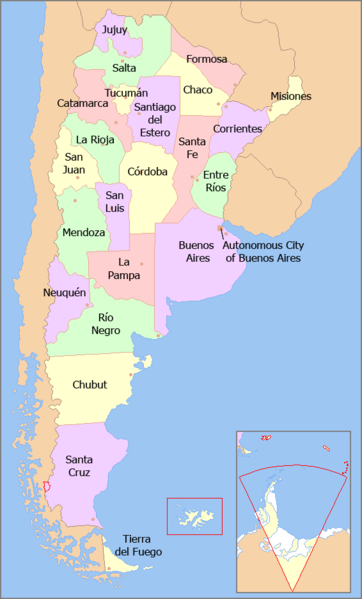

In [114]:
from IPython.display import Image
Image('https://upload.wikimedia.org/wikipedia/commons/thumb/9/9e/Map_of_Argentina_with_provinces_names_en.png/362px-Map_of_Argentina_with_provinces_names_en.png')

In [115]:
gadm1 = gpd.read_file(os.getenv('data')+'/GADM/GADM_ARG/gadm36_ARG_1.shp')
gadm2 = gpd.read_file(os.getenv('data')+'/GADM/GADM_ARG/gadm36_ARG_2.shp')

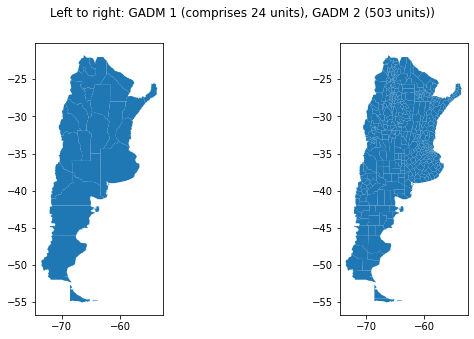

In [116]:
f,(ax1,ax2) = plt.subplots(ncols=2,figsize=[10,5])
gadm1.plot(ax=ax1)
gadm2.plot(ax=ax2)
plt.suptitle('Left to right: GADM 1 (comprises {} units), GADM 2 ({} units))'.format(len(gadm1),len(gadm2)));


In [117]:
gadm1.NAME_1.unique()

array(['Buenos Aires', 'Catamarca', 'Chaco', 'Chubut',
       'Ciudad de Buenos Aires', 'Córdoba', 'Corrientes', 'Entre Ríos',
       'Formosa', 'Jujuy', 'La Pampa', 'La Rioja', 'Mendoza', 'Misiones',
       'Neuquén', 'Río Negro', 'Salta', 'San Juan', 'San Luis',
       'Santa Cruz', 'Santa Fe', 'Santiago del Estero',
       'Tierra del Fuego', 'Tucumán'], dtype=object)

In [118]:
# level 2 units within Buenos Aires province or city
gadm2[gadm2.NAME_1.str.contains('Buenos')].NAME_2.unique()

array(['Adolfo Alsina', 'Adolfo Gonzales Chaves', 'Alberti',
       'Almirante Brown', 'Ameghino', 'Arrecifes', 'Avellaneda',
       'Ayacucho', 'Azul', 'Bahía Blanca', 'Balcarce', 'Baradero',
       'Benito Juárez', 'Berazategui', 'Berisso', 'Bolívar', 'Bragado',
       'Brandsen', 'Campana', 'Cañuelas', 'Capitán Sarmiento',
       'Carlos Casares', 'Carlos Tejedor', 'Carmen de Areco', 'Castelli',
       'Chacabuco', 'Chascomús', 'Chivilcoy', 'Colón',
       'Coronel de Marina Leonardo Rosales', 'Coronel Dorrego',
       'Coronel Pringles', 'Coronel Suárez', 'Daireaux', 'Dolores',
       'Ensenada', 'Escobar', 'Esteban Echeverría',
       'Exaltación de la Cruz', 'Florencio Varela', 'General Alvarado',
       'General Alvear', 'General Arenales', 'General Belgrano',
       'General Guido', 'General Juan Madariaga', 'General La Madrid',
       'General Las Heras', 'General Lavalle', 'General Paz',
       'General Pinto', 'General Pueyrredón', 'General Rodríguez',
       'General San Ma

#### 5. Only events that affected Buenos Aires (province or city)

In [119]:
df.location = df.location.str.lower()

In [120]:
mask = df.location.str.contains('buenos').fillna(False)
df_BA = df[mask][['year','location','total_damages','deaths']]
df_BA

,year,location,total_damages,deaths
1,1967,buenos aires suburbs,3000.0,56.0
7,1980,buenos aires province,NaN,31.0
12,1985,buenos aires,1300000.0,12.0
14,1987,northwest buenos aires province,NaN,NaN
15,1988,buenos aires province,490000.0,25.0
16,1990,buenos aires,NaN,21.0
17,1992,"minas, cruz del eje, san justo, punilla, rio s...",250000.0,45.0
18,1992,"formosa, misiones, corrientes, chaco, sante fe...",260000.0,NaN
19,1993,"junin, general viamonte, castelli, general pin...",400000.0,NaN
20,1993,buenos aires province,600000.0,NaN


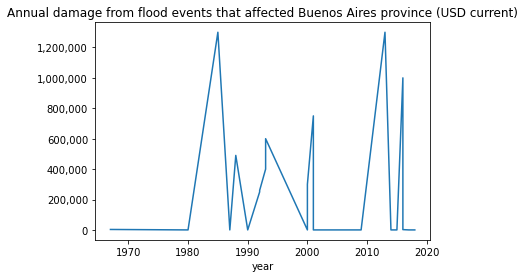

In [134]:
ax = df_BA.fillna(0).plot(x='year',y='total_damages',legend=False)
y_labels = ax.get_yticks()
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('Annual damage from flood events that affected Buenos Aires province (USD current)');

In [136]:
df_BA.to_csv('floods_BA.csv')